/var/folders/_7/2m4yw6kn1ps76w144k8c8frm0000gn/T/ipykernel_12170/4096303276.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stacked_sorted = stacked.groupby('app_name').apply(lambda x: x.sort_values(by='tfidf', ascending=False)).reset_index(drop=True)


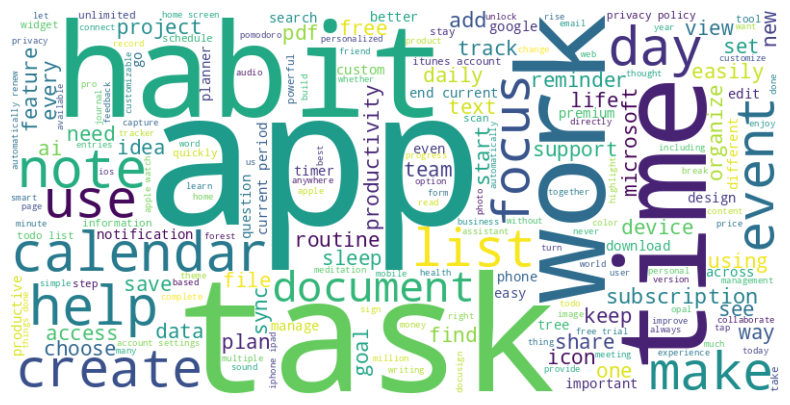

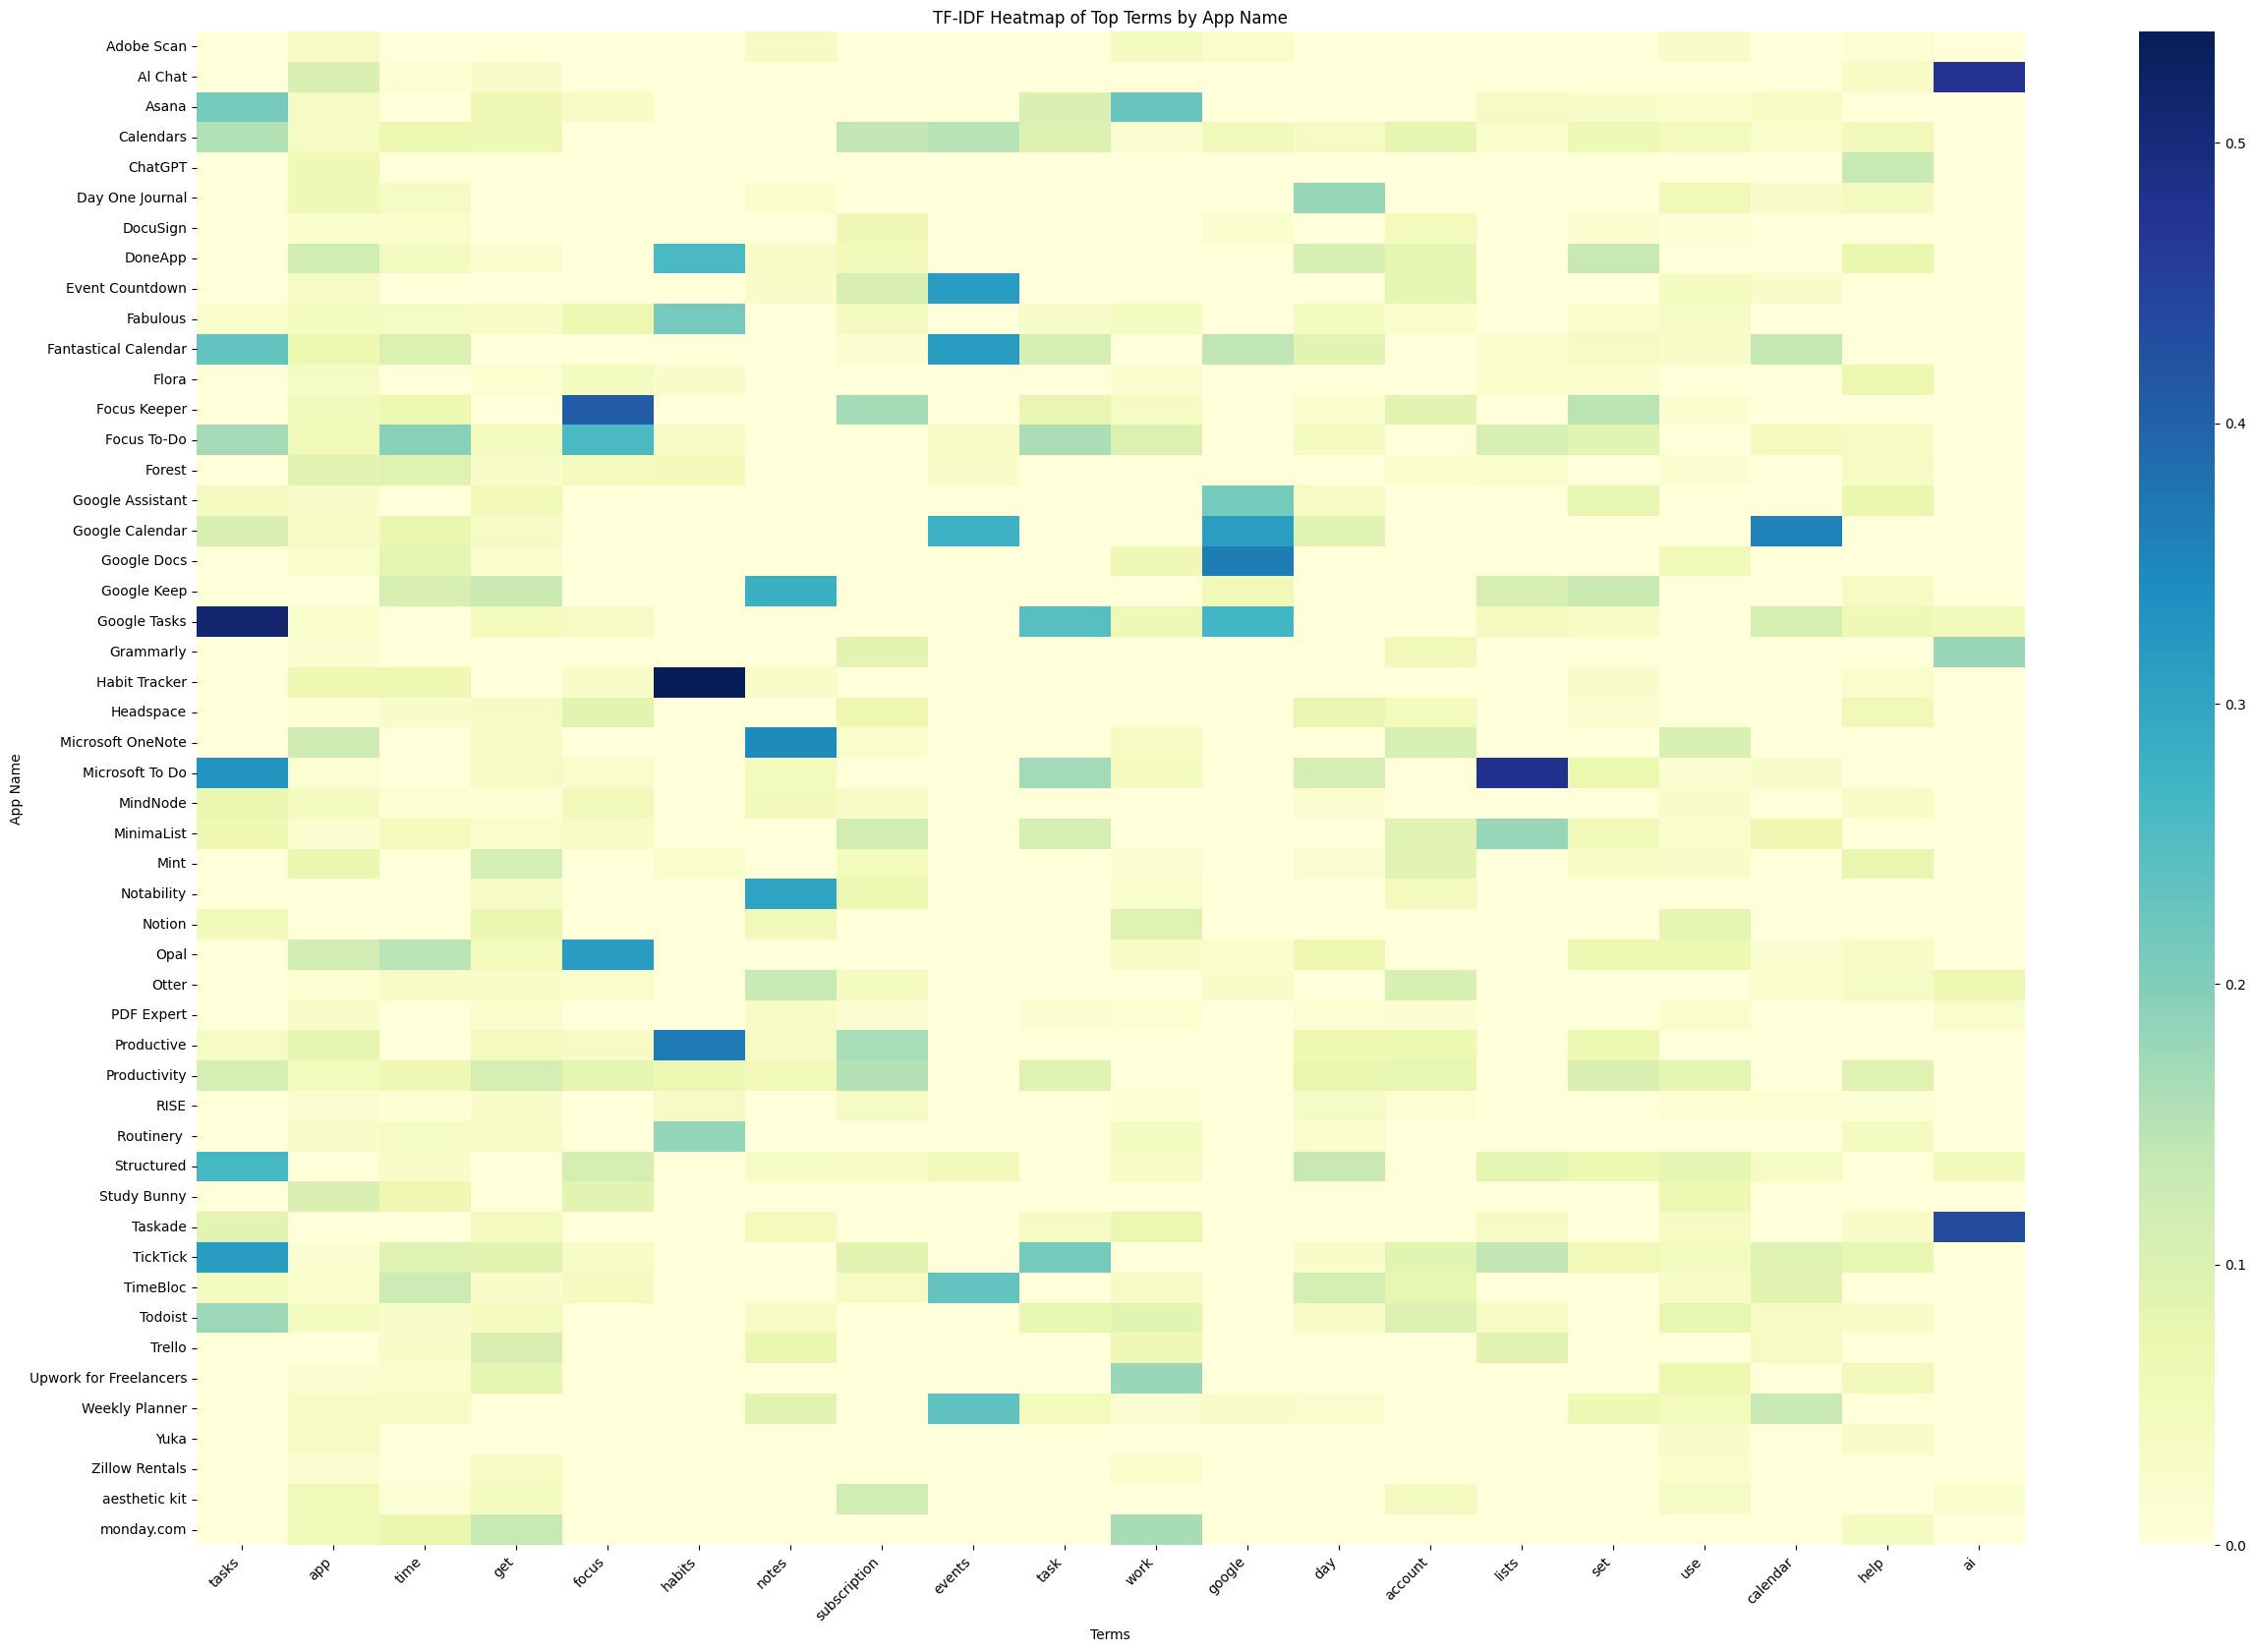

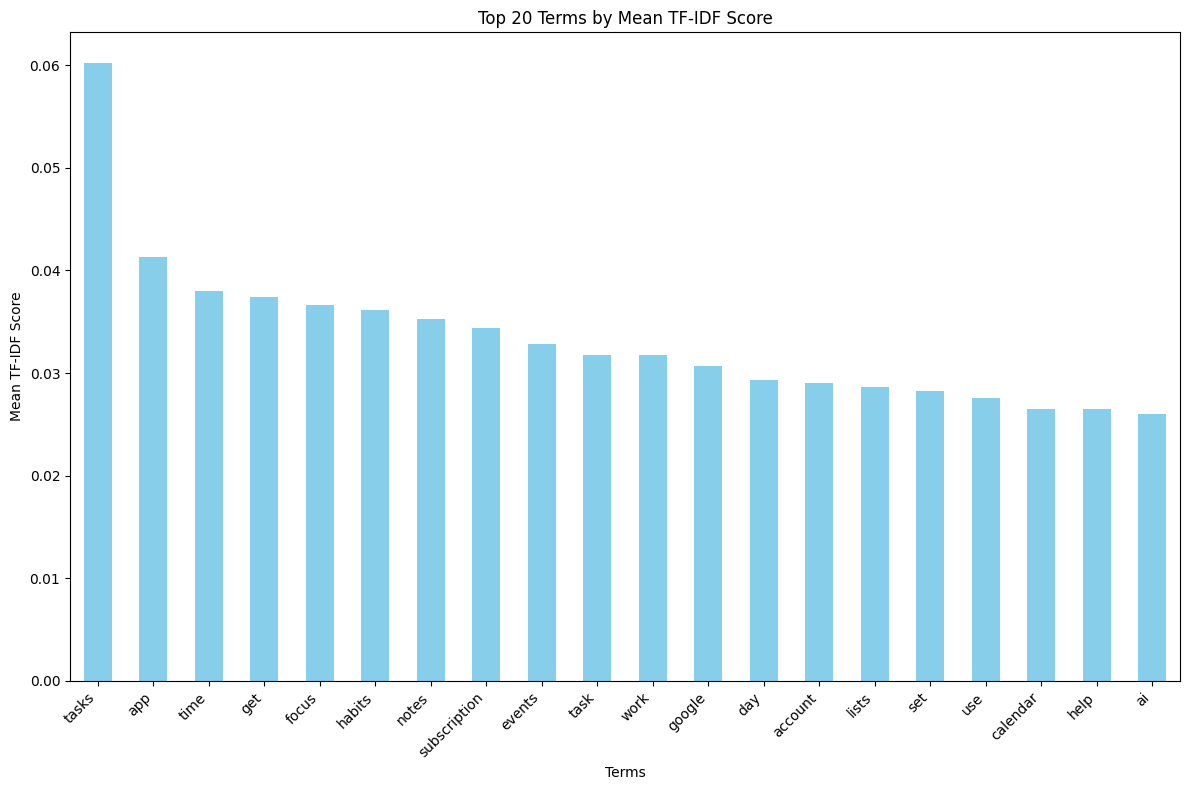

alt.LayerChart(...)

In [4]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import numpy as np
import altair as alt

df = pd.read_csv("../data/us/productivity-apps-f6853042c9b571c25c7560c4c867fec7.csv")
#df = pd.read_csv("../data/us/note-taking-8b1a7bb5c86f1c6811bfded34a03525c.csv")

# Clean the text data
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return " ".join(tokens)


# Apply the cleaning function to the 'description' column
df['clean_description'] = df['description'].apply(clean_text)

# Concatenate all cleaned descriptions
all_descriptions = ' '.join(df['clean_description'])

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer and transform the cleaned descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_description'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add 'app_name' column to TF-IDF DataFrame
df['app_name_clean'] = df['app_name'].apply(lambda x: x.split(":")[0])
df['app_name_clean'] = df['app_name_clean'].apply(lambda x: x.split(" -")[0])
tfidf_df['app_name'] = df['app_name_clean']

# Pivot the DataFrame to have 'app_name' as index
tfidf_pivot = tfidf_df.pivot_table(index='app_name', aggfunc='mean')

# Calculate the mean TF-IDF score for each term across all apps
mean_tfidf_scores = tfidf_pivot.mean(axis=0)

# Sort terms by mean TF-IDF score
mean_tfidf_scores_sorted = mean_tfidf_scores.sort_values(ascending=False)

# Select top terms by mean TF-IDF score (adjust the number as needed)
top_terms = mean_tfidf_scores_sorted[:20].index

# Filter the TF-IDF DataFrame to include only top terms
top_tfidf_df = tfidf_pivot[top_terms]

# Stack the DataFrame to have words as rows
stacked = tfidf_pivot.stack().reset_index()

stacked.columns = ['app_name', 'term', 'tfidf']

# Adding a little randomness to break ties in term ranking
stacked['tfidf'] = stacked['tfidf'] + np.random.rand(stacked.shape[0])*0.000001

# Sort the DataFrame by TF-IDF scores within each app_name group
stacked_sorted = stacked.groupby('app_name').apply(lambda x: x.sort_values(by='tfidf', ascending=False)).reset_index(drop=True)

# Calculate ranks within each app_name group
stacked_sorted['rank'] = stacked_sorted.groupby('app_name')['tfidf'].rank(ascending=False)

# Take the top 10
stacked_sorted = stacked_sorted[stacked_sorted['rank'] <=10]

# Shorten the string term
stacked_sorted['term'] = stacked_sorted['term'].apply(lambda x: x[:15]).astype(str)

# Plot the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Create the heatmap
plt.figure(figsize=(30, 20))
plt.xticks(rotation=45, ha='right')
sns.heatmap(top_tfidf_df, cmap="YlGnBu", annot=False)
plt.title("TF-IDF Heatmap of Top Terms by App Name")
plt.xlabel("Terms")
plt.ylabel("App Name", )
plt.show()

# Plot the top terms by mean TF-IDF score
plt.figure(figsize=(12, 8))
mean_tfidf_scores_sorted[:20].plot(kind='bar', color='skyblue')
plt.title('Top 20 Terms by Mean TF-IDF Score')
plt.xlabel('Terms')
plt.ylabel('Mean TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot the heatmap of top 10 words
alt.data_transformers.enable("vegafusion")
heatmap = alt.Chart(stacked_sorted).mark_rect().encode(
    x=alt.X('rank:O', title='Rank of Words'),
    y=alt.Y('app_name:N', title='App Name'),
    color=alt.Color('tfidf:Q', scale=alt.Scale(scheme='greens'), title='TF-IDF')
).properties(
    width=800,
    height=600
)

# terms in this list will get a red dot in the visualization
term_list = ['health', 'healthkit']

# Add text labels for words
text = heatmap.mark_text(baseline='middle').encode(
    text='term:N',
    color = alt.value('black')
)

# Combine heatmap and text
heatmap_with_text = (heatmap + text).properties(
    title='TF-IDF Heatmap'
)

heatmap_with_text